# Gaussian Processes with PyMC3

In [2]:
import pymc3 as pm
import numpy as np
from pymc3 import gp
from pymc3.gp import cov, Latent
from pymc3 import MvNormal, Normal, Bernoulli, Gamma, HalfCauchy, Uniform, Flat, Binomial, Exponential, HalfNormal
from pymc3 import traceplot, forestplot, summary, generator, energyplot
from pymc3.math import invprobit, invlogit
from pymc3.gp.util import plot_gp_dist
import seaborn as sns
import matplotlib.pylab as plt
import matplotlib.cm as cmap

import theano.tensor as tt
from theano import shared
import theano

%matplotlib inline

/Users/rsilvei/Envs/bayesian/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# function to display covariance matrices
def plot_cov(X, K, n_samples, stationary=True):
    K = K + 1e-8*np.eye(X.shape[0])
    x = X.flatten()
    
    with sns.axes_style("white"):

        fig = plt.figure(figsize=(14,5))
        ax1 = fig.add_subplot(121)
        m = ax1.imshow(K, cmap="inferno", 
                       interpolation='none', 
                       extent=(np.min(X), np.max(X), np.max(X), np.min(X))); 
        plt.colorbar(m);
        ax1.set_title("Covariance Matrix")
        ax1.set_xlabel("X")
        ax1.set_ylabel("X")

        ax2 = fig.add_subplot(122)
        if not stationary:
            ax2.plot(x, np.diag(K), "k", lw=2, alpha=0.8)
            ax2.set_title("The Diagonal of K")
            ax2.set_ylabel("k(x,x)")
        else:
            ax2.plot(x, K[:,0], "k", lw=2, alpha=0.8)
            ax2.set_title("K as a function of x - x'")
            ax2.set_ylabel("k(x,x')")
        ax2.set_xlabel("X")

        fig = plt.figure(figsize=(14,4))
        ax = fig.add_subplot(111)
        samples = np.random.multivariate_normal(np.zeros(num_points), K, n_samples).T;
        for i in range(samples.shape[1]):
            #ax.plot(x, samples[:,i], color=cmap.inferno(i*0.2), lw=2);
            ax.plot(x, samples[:,i], color=cmap.inferno(i*0.1), lw=2);
        ax.set_title("Samples from GP Prior")
        ax.set_xlabel("X")

## Gaussian Regression -- Input Signal

In [3]:
num_points = 200
x = np.linspace(-10, 10, num = num_points).reshape(-1,1)
noise = np.random.normal(loc = 20, scale = 80, size = num_points).reshape(-1,1)
y = x**3 + noise
y = y.squeeze(1)

In [1]:
plt.figure(figsize=(12,8))
plt.scatter(x,y)
plt.grid()

NameError: name 'plt' is not defined

# Some Covariance Functions

## Matern $\nu=3/2$ covariance

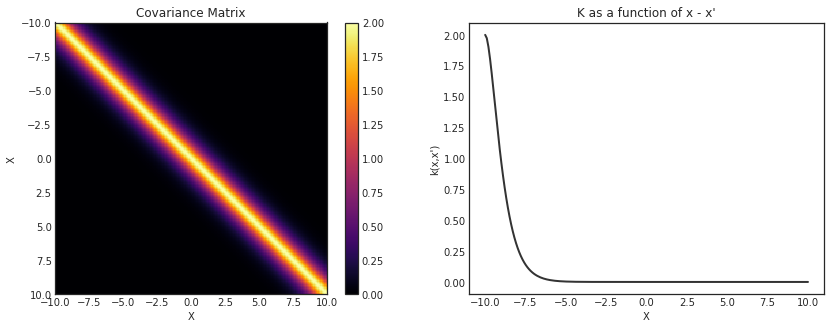

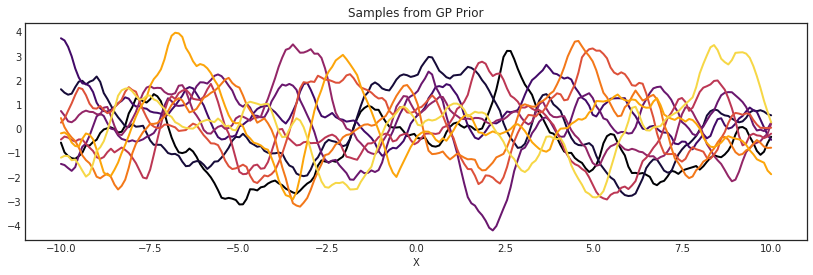

In [5]:
with pm.Model() as model:
    l = 1
    tau = 2.0
    cov = tau * pm.gp.cov.Matern32(1,l)

K = theano.function([], cov(x))()

plot_cov(x, K, n_samples=10)

## Matern $\nu=5/2$ covariance

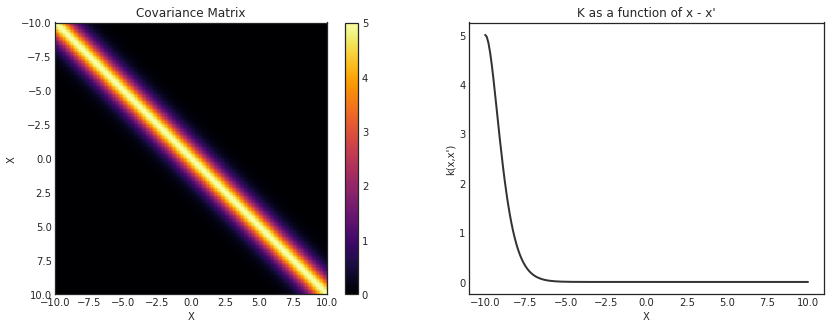

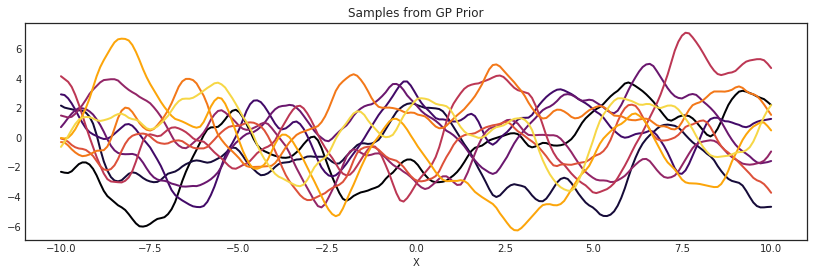

In [6]:
with pm.Model() as model:
    l = 1
    tau = 5.0
    cov = tau * pm.gp.cov.Matern52(1,l)

K = theano.function([], cov(x))()

plot_cov(x, K, n_samples=10)

## Quadratic exponential covariance

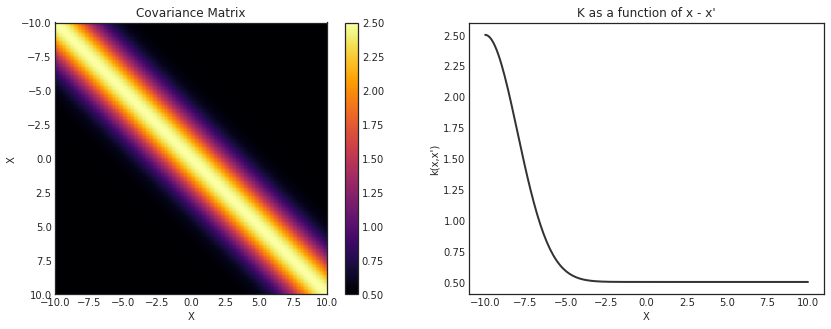

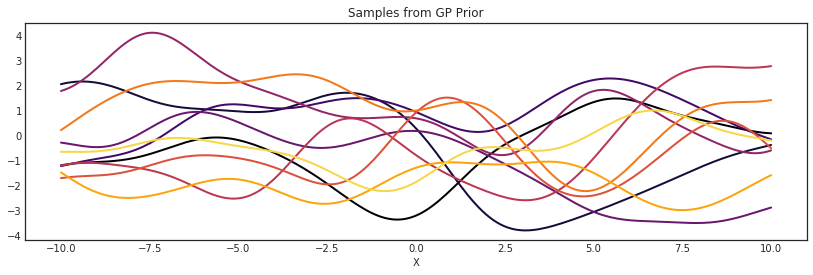

In [7]:
with pm.Model() as model:
    l = 2
    tau = 2.0
    b = 0.5
    cov = b + tau * pm.gp.cov.ExpQuad(1, l)

K = theano.function([], cov(x))()

plot_cov(x, K, n_samples=10)

## Cosine covariance

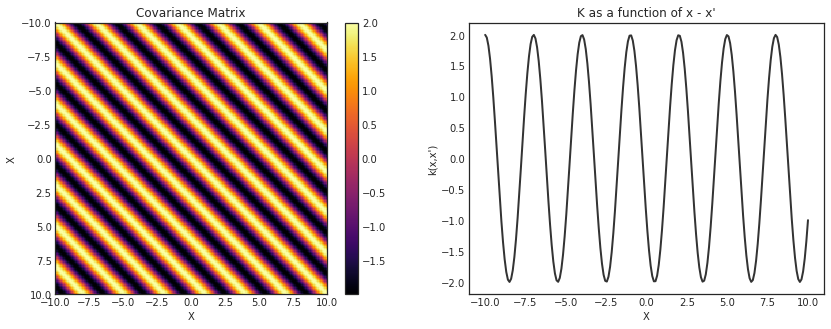

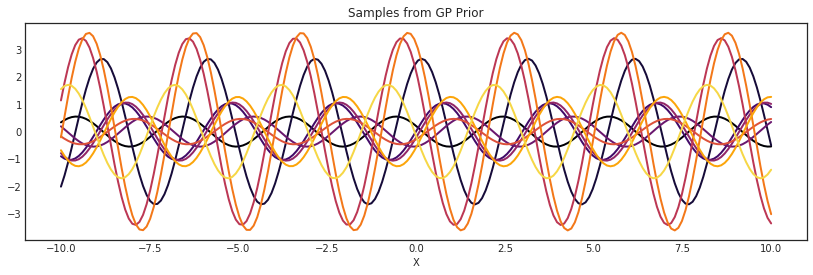

In [8]:
with pm.Model() as model:
    l = 3
    tau = 2.0
    cov = tau * pm.gp.cov.Cosine(1, l)

K = theano.function([], cov(x))()

plot_cov(x, K, n_samples=10)

## Fit Gaussian Processes using PyMC3

In [9]:
with pm.Model() as fit_model:

    ρ = pm.HalfCauchy('ρ', 3)
    η = pm.HalfCauchy('η', 3)
    
    ## Mean
    M = pm.gp.mean.Zero()
    
    ## Covariance
    cov = η * pm.gp.cov.ExpQuad(1, ρ) 
    
    gp = pm.gp.Marginal(mean_func=M, cov_func=cov)
    
    noise_sig = pm.HalfCauchy('σ', 2.5)
    likelyhood = gp.marginal_likelihood('likelyhood', 
                                      X=x, 
                                      y=y, 
                                      noise=noise_sig**2)

In [10]:
with fit_model:
    start = pm.find_MAP()
    step = pm.NUTS()
    trace = pm.sample(2000, 
                      cores=2, 
                      chains=2, 
                      tune=500, 
                      step=step, 
                      start=start,
                      progressbar=True,
                      njobs=1)

logp = -1,487, ||grad|| = 0.044544: 100%|██████████| 38/38 [00:00<00:00, 109.26it/s]    
Sequential sampling (2 chains in 1 job)
NUTS: [σ_log__, η_log__, ρ_log__]
100%|██████████| 2500/2500 [02:05<00:00, 19.88it/s]


In [11]:
## Test range
test_range = np.linspace(-20, 20, 100).reshape(-1, 1)

In [12]:
with fit_model:
    fit_pred = gp.conditional("fit_pred", test_range)
    fit_samples = pm.sample_ppc(trace, vars=[fit_pred], samples=100)

100%|██████████| 100/100 [00:01<00:00, 84.65it/s]


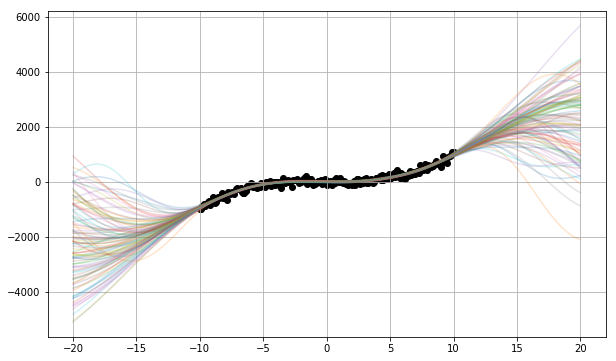

In [13]:
plt.figure(figsize = (10,6))
plt.scatter(x,y,c='k')
for sample in fit_samples['fit_pred']:
    plt.plot(test_range,sample, alpha = 0.2)
plt.grid()

## Fitting Different Input

In [25]:
num_points = 80
x = np.linspace(-10, 10, num = num_points).reshape(-1,1)
noise = np.random.normal(loc = 2, scale = 5, size = num_points).reshape(-1,1)
y = 50* np.cos(x) + noise
y = y.squeeze(1)

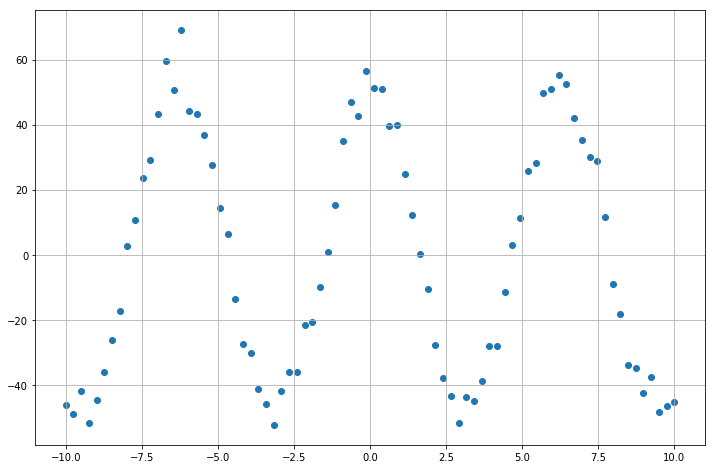

In [26]:
plt.figure(figsize=(12,8))
plt.scatter(x,y)
plt.grid()

## Testing with different Kernel (Matern52)

In [27]:
with pm.Model() as fit_model_2:  

    ρ = pm.HalfCauchy('ρ', 3)
    η = pm.HalfCauchy('η', 3)
    
    ## Mean
    M = pm.gp.mean.Zero()
    
    ## Covariance
    cov = η * pm.gp.cov.Matern32(1, ρ)
    
    gp = pm.gp.Marginal(mean_func=M, cov_func=cov)
    
    noise_sig = pm.HalfCauchy('σ', 2.5)
    likelyhood = gp.marginal_likelihood('likelyhood', 
                                      X=x, 
                                      y=y, 
                                      noise=noise_sig**2)

In [28]:
with fit_model_2:
    start = pm.find_MAP()
    step = pm.NUTS()
    trace_2 = pm.sample(500, 
                  cores=2, 
                  chains=4, 
                  tune=200, 
                  step=step, 
                  start=start,
                  progressbar=True,
                  njobs=1)

logp = -408.68, ||grad|| = 9.2593e-05: 100%|██████████| 35/35 [00:00<00:00, 352.58it/s]  
Sequential sampling (4 chains in 1 job)
NUTS: [σ_log__, η_log__, ρ_log__]
100%|██████████| 700/700 [00:09<00:00, 75.14it/s]
The acceptance probability does not match the target. It is 0.9160299449855026, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.928988820318556, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9030892564752487, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9087143486705442, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


In [29]:
with fit_model_2:
    fit_pred_2 = gp.conditional("fit_pred_2", test_range)
    fit_samples_2 = pm.sample_ppc(trace_2, 
                                  vars=[fit_pred_2], 
                                  samples=50)

100%|██████████| 50/50 [00:00<00:00, 63.11it/s]


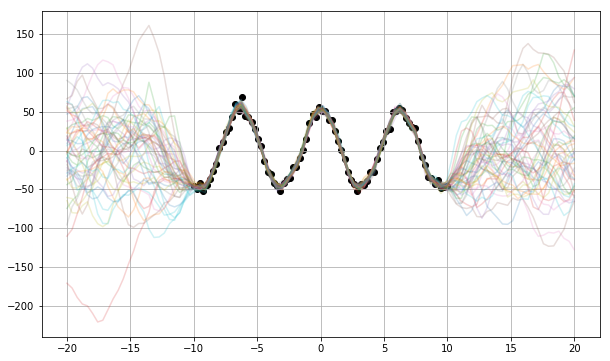

In [31]:
plt.figure(figsize = (10,6))
plt.scatter(x,y,c='k')
for sample in fit_samples_2['fit_pred_2']:
    plt.plot(test_range,sample, alpha = 0.2)
plt.grid()

## Test with Periodic Kernel (Cosine)

In [32]:
with pm.Model() as fit_model_3:
    ρ = pm.HalfCauchy('ρ', 3)
    η = pm.HalfCauchy('η', 3)

    ## Mean
    M = pm.gp.mean.Zero()
    
    ## Covariance
    cov = η * pm.gp.cov.Cosine(1, ρ)
    
    ## Gaussian Process
    gp = pm.gp.Marginal(mean_func=M, cov_func=cov)
    
    ## Noise and Likelihood
    noise_sig = pm.HalfCauchy('σ', 2.5)
    likelyhood = gp.marginal_likelihood('likelyhood', 
                                      X=x, 
                                      y=y, 
                                      noise=noise_sig**2)

In [33]:
with fit_model_3:
    start = pm.find_MAP()
    step = pm.NUTS()
    trace_3 = pm.sample(500, 
              cores=2, 
              chains=2, 
              tune=200, 
              step=step, 
              start=start,
              progressbar=True,
              njobs=1)

logp = -408.69, ||grad|| = 0.028859: 100%|██████████| 32/32 [00:00<00:00, 332.28it/s]  
Sequential sampling (2 chains in 1 job)
NUTS: [σ_log__, η_log__, ρ_log__]
100%|██████████| 700/700 [02:20<00:00,  4.99it/s]
The acceptance probability does not match the target. It is 0.9177912180946995, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8995842942764004, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


In [34]:
with fit_model_3:
    fit_pred_3 = gp.conditional("fit_pred_3", test_range)
    fit_samples_3 = pm.sample_ppc(trace_3, 
                                  vars=[fit_pred_3], 
                                  samples=50)

100%|██████████| 50/50 [00:00<00:00, 59.08it/s]


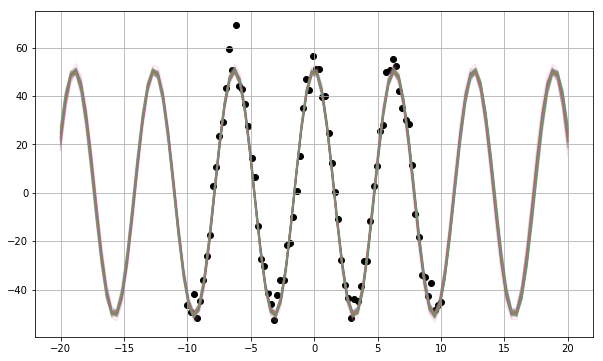

In [35]:
plt.figure(figsize = (10,6))
plt.scatter(x,y,c='k')
for sample in fit_samples_3['fit_pred_3']:
    plt.plot(test_range,sample, alpha = 0.2)
plt.grid()